In [1]:
import utils
import pandas
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

from datetime import datetime, date

from scipy.misc import imresize
import features

import json

In [2]:
verbose = 0

In [3]:
from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2S
from sklearn.isotonic import check_increasing

from scipy.stats import pearsonr

List of users

    anamaria16          eightturncrepeny  iceandvice             minastaartenwereld  taiyakinyc
    cake.and.sweets.17  ezgipolat         instagram-scraper.log  muradosmann         way_cake
    carlifestyle        garrylarduinat    jacquesgenin           omjsk               zachking
    carolina_nusadua    gunopark          jamesjeanart           pierreherme
    cedricgrolet        helloemilie       joannagaines           pollykosheleva
    danbilzerian        hungrygrls        lolly_cakery           somepaintings
    dinarakasko         iamdessertlover   menwithstreetstyle     stuffbeneats

List of tags

    posts3_cake_1505409284.json        posts_icecream_1505846777.json
    images_cake_1505409284.npy         posts3_cakes_1505469028.json     posts_latte_1505845000.json
    images_cakes_1505441948.npy        posts3_icecream_1505846777.json

In [5]:
# Load Data

userSpecific = False

if userSpecific:
    posts,images = utils.dataFromScraper('jamesjeanart')
    dfp = pandas.DataFrame(posts)
    bytag = False
    
else:
    bytag = True
    posts, images = utils.getData('posts_cakes_1505469028.json',updated=True,rawimages=True)
    with open('data/users_cakes_1505469028.json','r') as infile:
            users = json.load(infile)
    dfu = pandas.DataFrame(users)
    dfp = pandas.DataFrame(posts)

In [6]:
"""
Get features from raw data
"""

# Extract image features

nbins = 20
nposts0 = len(posts)
satH = np.zeros([nposts0,nbins])
conH = np.zeros([nposts0,nbins])
sat = np.zeros(nposts0)
contrast = np.zeros(nposts0)

dims = 5
comp = np.zeros([nposts0,dims**2])

kernelCos,kernelSin,kernelCor1,kernelCor2,kernelCor3,kernelCor4 = features.compKernels(dims)
kCos = np.zeros(nposts0)
kSin = np.zeros(nposts0)
kCor1 = np.zeros(nposts0)
kCor2 = np.zeros(nposts0)
kCor3 = np.zeros(nposts0)
kCor4 = np.zeros(nposts0)

for i in range(len(posts)):
    satH[i],_ = np.histogram(features.colorfulness(images[i]), bins=nbins)
    satH[i] = satH[i]/np.sqrt(np.sum(satH[i]**2))
    sat[i] = np.mean(features.colorfulness(images[i]))
    intensity = np.mean(images[i],2)
    conH[i],_ = np.histogram(intensity, bins=nbins)
    conH[i] = conH[i]/np.sqrt(np.sum(conH[i]**2))
    contrast[i] = features.contrast(images[i])
    comp[i] = imresize(intensity,[dims,dims]).reshape([dims**2])

    temp = imresize(intensity,[dims,dims])
    kCos[i] = np.mean(temp*kernelCos)
    kSin[i] = np.mean(temp*kernelSin)
    kCor1[i] = np.mean(temp*kernelCor1)
    kCor2[i] = np.mean(temp*kernelCor2)
    kCor3[i] = np.mean(temp*kernelCor3)
    kCor4[i] = np.mean(temp*kernelCor4)
    

# Extract metadata features

likes = dfp['likes'].apply(lambda x: float(features.convertString(x))).values
ntags = dfp[u'caption'].apply(lambda x: float( len(x.split(' #')) ) ).values - 1

if userSpecific:
    hour = dfp[u'createdtime'].apply(lambda x: features.extractTimeData(x)[1]).values
    weekday = dfp[u'createdtime'].apply(lambda x: features.extractTimeData(x)[0]).values

if bytag:
    followers = dfu['followers'].apply(lambda x: float( features.convertString(x) )).values
    following = dfu['following'].apply(lambda x: features.convertString(x)).values
    user_nposts = dfu[u'nposts'].apply(lambda x: features.getnposts(x)).values
    hour = dfp[u'date'].apply(lambda x: features.extractTimeData(x)[1]).values
    weekday = dfp[u'date'].apply(lambda x: features.extractTimeData(x)[0]).values
    meanlikes = dfu[u'meanlikes'].values
    mult = dfp[u'ismultiple'].values

a = np.array([1, 0, 3])
weekdayvec = np.zeros([nposts0,8])
hourvec = np.zeros([nposts0,26])
weekdayvec[np.arange(nposts0), weekday] = 1
hourvec[np.arange(nposts0), hour] = 1


In [7]:
counter = 0
meanlikes2 = meanlikes
for i in range(nposts0):
    if np.isnan(meanlikes[i]):
        counter+=1
        meanlikes2[i] = 0.
print counter
print np.mean(meanlikes2)

73
4.6558159308


In [8]:
"""
Normalize data
"""

# minsat = np.min(sat)
# maxsat = np.max(sat)
# mincon = np.min(contrast)
# maxcon = np.max(contrast)
# minlike = min(likes)
# maxlike = max(likes)
# mintags = min(ntags)
# maxtags = max(ntags)

# normSinA = np.abs(kSin)/np.max(np.abs(kSin))

# normsat = (sat - minsat)/(maxsat-minsat)
# normcontrast = (contrast - mincon)/(maxcon-mincon)
# normlikes = (likes - minlike)/(maxlike - minlike)
# normcomp = comp/255.
# normNtags = (ntags - np.mean(ntags))/(maxtags - mintags)
# normCos = (kCos - np.mean(kCos))/(np.max(kCos) - np.min(kCos))
# normSin = (kSin - np.mean(kSin))/(np.max(kSin) - np.min(kSin))



    
# Vectorize data

if bytag:
    
    nfeatures = 3*(1+2+4+1+1+1)+7+24+4+1
    nMetaFeatures = 7+24+4+1
    data = np.zeros([nposts0,nfeatures])
    data[:,0] = kCos
    data[:,1] = kSin
    data[:,2] = np.abs(kSin)
    data[:,3] = kCor1
    data[:,4] = kCor2
    data[:,5] = kCor3
    data[:,6] = kCor4
    data[:,7] = sat
    data[:,8] = contrast
    data[:,9] = ntags
    data[:,10] = kCos**2
    data[:,11] = kSin**2
    data[:,12] = np.abs(kSin)**2
    data[:,13] = kCor1**2
    data[:,14] = kCor2**2
    data[:,15] = kCor3**2
    data[:,16] = kCor4**2
    data[:,17] = sat**2
    data[:,18] = contrast**2
    data[:,19] = ntags**2
    data[:,20] = kCos**3
    data[:,21] = kSin**3
    data[:,22] = np.abs(kSin)**3
    data[:,23] = kCor1**3
    data[:,24] = kCor2**3
    data[:,25] = kCor3**3
    data[:,26] = kCor4**3
    data[:,27] = sat**3
    data[:,28] = contrast**3
    data[:,29] = ntags**3
    data[:,30:37] = weekdayvec[:,0:7]
    data[:,37:61] = hourvec[:,0:24]
    data[:,61] = mult
    data[:,62] = followers
    data[:,63] = following
    data[:,64] = user_nposts
    data[:,65] = meanlikes2

elif False:

    nfeatures = 1+2+4+1+1+1+7+24+4+1
    data = np.zeros([nposts0,nfeatures])
    data[:,0] = kCos
    data[:,1] = kSin
    data[:,2] = np.abs(kSin)
    data[:,3] = kCor1
    data[:,4] = kCor2
    data[:,5] = kCor3
    data[:,6] = kCor4
    data[:,7] = sat
    data[:,8] = contrast
    data[:,9] = ntags
    data[:,10:17] = weekdayvec[:,0:7]
    data[:,17:41] = hourvec[:,0:24]
    data[:,41] = mult
    data[:,42] = followers
    data[:,43] = following
    data[:,44] = user_nposts
    data[:,45] = meanlikes2

else:
    
    nfeatures = 1+2+4+1+1+1+7+24+4+1
    data = np.zeros([nposts0,nfeatures])
    data[:,0] = kCos
    data[:,1] = kSin
    data[:,2] = np.abs(kSin)
    data[:,3] = kCor1
    data[:,4] = kCor2
    data[:,5] = kCor3
    data[:,6] = kCor4
    data[:,7] = sat
    data[:,8] = contrast
    data[:,9] = ntags
    data[:,10:17] = weekdayvec[:,0:7]
    data[:,17:] = hourvec[:,0:24]




# Set normalization bounds

minvals = np.zeros([nfeatures])
maxvals = np.ones([nfeatures])
centervals = np.zeros([nfeatures])

min_y = min(likes)
max_y = max(likes)
center_y = min(likes)

if bytag:
    
    minvals[0] = np.min(data[:,0])
    minvals[1] = np.min(data[:,1])
    minvals[7] = np.min(data[:,7])
    minvals[8] = np.min(data[:,8])
    minvals[9] = np.min(data[:,9])
    for i in (np.arange(20)+10).tolist():
        minvals[i] = np.min(data[:,i])
    minvals[54] = np.min(user_nposts)
    minvals[55] = np.min(meanlikes2)

    maxvals[0] = np.max(data[:,0])
    maxvals[1] = np.max(data[:,1])
    maxvals[2] = np.max(data[:,2])
    maxvals[3] = np.max(data[:,3])
    maxvals[4] = np.max(data[:,4])
    maxvals[5] = np.max(data[:,5])
    maxvals[6] = np.max(data[:,6])
    maxvals[7] = np.max(data[:,7])
    maxvals[8] = np.max(data[:,8])
    maxvals[9] = np.max(data[:,9])
    for i in (np.arange(20)+10).tolist():
        maxvals[i] = np.max(data[:,i])
    #maxvals[20:27]
    #maxvals[27:51]
    #maxvals[51]
    maxvals[52] = followers[ followers.argsort()[int(nposts0*.85)] ]
    maxvals[53] = following[ following.argsort()[int(nposts0*.85)] ]
    maxvals[54] = np.max(user_nposts)
    maxvals[55] = np.max(meanlikes2)

    centervals[0] = np.mean(kCos)
    centervals[1] = np.mean(kSin)
    centervals[2] = np.mean(data[:,2])
    centervals[3] = np.mean(data[:,3])
    centervals[4] = np.mean(data[:,4])
    centervals[5] = np.mean(data[:,5])
    centervals[6] = np.mean(data[:,6])
    centervals[7] = np.min(sat)
    centervals[8] = np.min(contrast)
    centervals[9] = np.mean(ntags)
    for i in (np.arange(20)+10).tolist():
        centervals[i] = np.mean(data[:,i])
    centervals[52] = np.mean(data[:,52])
    centervals[53] = np.mean(data[:,53])
    centervals[54] = np.mean(data[:,54])
    centervals[55] = np.mean(data[:,55])

elif False:
    
    minvals[0] = np.min(kCos)
    minvals[1] = np.min(kSin)
    #maxvals[2] = 0.
    #maxvals[3] = 0
    #maxvals[4] = 0
    #maxvals[5] = 0
    #maxvals[6] = 0
    minvals[7] = np.min(sat)
    minvals[8] = np.min(contrast)
    minvals[9] = np.min(ntags)
    #minvals[10:17]
    #minvals[17:41]
    #minvals[41]
    #minvals[42] = 0
    #minvals[43] = 0
    #minvals[44] = np.min(user_nposts)
    #minvals[45] = np.min(meanlikes2)

    maxvals[0] = np.max(kCos)
    maxvals[1] = np.max(kSin)
    maxvals[2] = np.max(np.abs(kSin))
    maxvals[3] = np.max(kCor1)
    maxvals[4] = np.max(kCor2)
    maxvals[5] = np.max(kCor3)
    maxvals[6] = np.max(kCor4)
    maxvals[7] = np.max(sat)
    maxvals[8] = np.max(contrast)
    maxvals[9] = np.max(ntags)
    #maxvals[10:17]
    #maxvals[17:41]
    #maxvals[41]
    maxvals[42] = followers[ followers.argsort()[int(nposts0*.85)] ]
    maxvals[43] = following[ following.argsort()[int(nposts0*.85)] ]
    maxvals[44] = np.max(user_nposts)
    maxvals[45] = np.max(meanlikes2)

    centervals[0] = np.mean(kCos)
    centervals[1] = np.mean(kSin)
    #centervals[2] = 0.
    #centervals[3] = 0
    #centervals[4] = 0
    #centervals[5] = 0
    #centervals[6] = 0
    centervals[7] = np.min(sat)
    centervals[8] = np.min(contrast)
    centervals[9] = np.mean(ntags)
    #centervals[10:17]
    #centervals[17:41]
    #centervals[41]
    #centervals[42] = 0
    #centervals[43] = 0
    #centervals[44] = np.min(user_nposts)
    #centervals[45] = np.max(meanlikes2)

else:
    
    minvals[0] = np.max(kCos)
    minvals[1] = np.max(kSin)
    minvals[2] = np.max(np.abs(kSin))
    minvals[3] = np.max(kCor1)
    minvals[4] = np.max(kCor2)
    minvals[5] = np.max(kCor3)
    minvals[6] = np.max(kCor4)
    minvals[7] = np.max(sat)
    minvals[8] = np.max(contrast)
    minvals[9] = np.max(ntags)
    #minvals[10:17]
    #minvals[17:]

    maxvals[0] = np.min(kCos)
    maxvals[1] = np.min(kSin)
    #maxvals[2] = 0.
    #maxvals[3] = 0
    #maxvals[4] = 0
    #maxvals[5] = 0
    #maxvals[6] = 0
    maxvals[7] = np.min(sat)
    maxvals[8] = np.min(contrast)
    maxvals[9] = np.min(ntags)
    #maxvals[10:17]
    #maxvals[17:]

    centervals[0] = np.mean(kCos)
    centervals[1] = np.mean(kSin)
    #centervals[2] = 0.
    #centervals[3] = 0
    #centervals[4] = 0
    #centervals[5] = 0
    #centervals[6] = 0
    centervals[7] = np.min(sat)
    centervals[8] = np.min(contrast)
    centervals[9] = np.mean(ntags)
    #centervals[10:17]
    #centervals[17:]

    
    


# Normalize data

for i in range(nfeatures):
    data[:,i] = (data[:,i] - centervals[i]) / (maxvals[i] - minvals[i])
    
y_orig = (likes - center_y) / (max_y - min_y)


With all features:
MSE: 0.000009
R2S: 0.782537
Features by order of importance: 
[65 62 64  0 16 10 14 24 27 19 17  9 13 25 23 29  3  6  5 33 31 30 32 49 48
 12 11 47 46 44 45 50 51 55 56 57 58 59 60 54 52 34 35 53 43 42 38 37 36 40
 41 39 20  1 61  4  8  7 15 18 63 28  2 26 21 22]


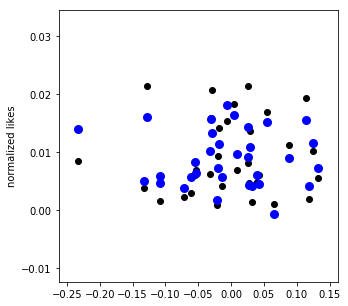

(67, 67) (67, 67)


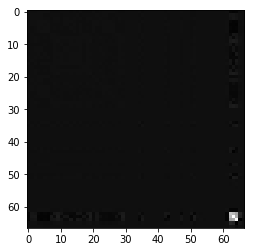

[-0.05607224  0.05675224  0.04026938 -0.07083878 -0.0599739  -0.0838678
 -0.07877072 -0.04511433  0.02139277  0.07840166  0.04833747 -0.04089132
 -0.04089132  0.03193649  0.03585634  0.05369745 -0.0445859  -0.03619827
  0.01176755  0.08267524 -0.04017136  0.04035131 -0.04758897 -0.05110153
 -0.0416297  -0.05553685 -0.04750209 -0.02761641 -0.02235552  0.07839616
  0.          0.          0.          0.         -0.03929196  0.03929196
  0.          0.          0.          0.          0.          0.          0.0428075
  0.06505785  0.          0.          0.         -0.06831718  0.          0.
  0.08344697 -0.0900752   0.00384961 -0.00783965  0.00342183  0.          0.
  0.          0.          0.          0.          0.0501191   1.11043471
  0.94151688 -0.53893943  0.22981139  0.04274849]


In [9]:
"""
Engineer data and fit basic models for use in feature selection
"""

# Get rid of samples with erratic properties, as well as outliers
    
keep = (likes < 10000) & (likes > 1) #& (ntags < 18)
keep = dfp.apply(features.not_in_list,args=[u'fashion',0],axis=1).values & keep

if bytag:
    likeOrder = likes.argsort()
    keep = np.zeros(nposts0, dtype=bool)
    keep[ likeOrder[int(nposts0*.05):int(nposts0*.90)].tolist() ] = True
    followOrder = followers.argsort()
    keep[ followOrder[int(nposts0*.85):].tolist() ] = False
    
    meanOrder = meanlikes2.argsort()
    keep[ meanOrder[:int(nposts0*.05)].tolist() ] = False
    keep[ meanOrder[int(nposts0*.95):].tolist() ] = False
    keep = keep & (meanlikes2 > 0.00001)

elif True:
    likeOrder = likes.argsort()
    keep = np.zeros(nposts0, dtype=bool)
    keep[ likeOrder[int(nposts0*.05):int(nposts0*.90)].tolist() ] = True

goodData = data[keep,:]
y = y_orig[keep]


# Split into test and training sets

nposts = len(goodData)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == .3)
crossval = ((np.arange(nposts) % 10) == 1) | ((np.arange(nposts) % 10) == .3)
train = np.logical_not(test) & np.logical_not(crossval)
ntrain = len(np.where(train)[0])
ncross = len(np.where(crossval)[0])


# Run regression with each feature missing
# so that we can see each feature's effect on the R^2 score

MSE_results = np.zeros(nfeatures)
R2S_results = np.zeros(nfeatures)

for i in range(nfeatures):

    featureList = [True]*nfeatures
    featureList[i] = False
    
    temp = goodData[:,featureList]

    data_train = temp[train,:]
    data_cross = temp[crossval,:]
    data_test = temp[test,:]

    y_train = y[train]
    y_cross = y[crossval]
    y_test = y[test]

    regr = linear_model.LinearRegression()
    regr.fit(data_train, y_train)

    y_pred = regr.predict(data_cross)

    MSE_results[i] = MSE(y_cross, y_pred)
    R2S_results[i] = R2S(y_cross, y_pred)
    
    if verbose > 2:
        print 'Without feature %02i:'%i
        print 'MSE: %8f'%MSE_results[i]
        print 'R2S: %8f'%R2S_results[i]
    

# Run regression on all features

data_train = goodData[train,:]
data_cross = goodData[crossval,:]
data_test = goodData[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_cross)

MSEall = MSE(y_cross, y_pred)
R2Sall = R2S(y_cross, y_pred)

print ''
print 'With all features:'
print 'MSE: %8f'%MSEall
print 'R2S: %8f'%R2Sall


print 'Features by order of importance: '
print R2S_results.argsort()
    
if True:

    fig = plt.figure(figsize=[5,5])
    feat = 0
    plt.scatter(data_cross[:,feat], y_cross,  color='black')
    plt.scatter(data_cross[:,feat], y_pred, color='blue', linewidth=3)
    #plt.xlabel('normalized contrast')
    plt.ylabel('normalized likes')
    plt.show()

    cov = np.cov(np.append(data_train,y_train.reshape([ntrain,1]),axis=1).transpose())
    #rescale = (lambda x: np.sqrt(x) if (x >= 0) else -np.sqrt(-x))
    covplot = cov
    
    indices = (cov >= 0)
    print indices.shape, cov.shape
    covplot[indices] = np.power(cov[indices],.3)
    meanpos = np.mean(covplot[indices])
    
    indices = (cov < 0)
    covplot[indices] = -np.power(-cov[indices],.3)
    meanneg = np.mean(covplot[indices])
    
    if False:
        covplot = np.append(covplot[:,:38],covplot[:,41:],axis=1)
        covplot = np.append(covplot[:,:9],covplot[:,30:],axis=1)
        covplot = np.append(covplot[:38,:],covplot[41:,:],axis=0)
        covplot = np.append(covplot[:9,:],covplot[30:,:],axis=0)
        limit = np.max( np.array([-meanneg,meanpos]) )*0.3
        plt.imshow(covplot,cmap='bwr',vmin=-limit,vmax=limit)
    else:
        plt.imshow(covplot,cmap='gray')
    plt.show()
    print cov[-1,:] #, data_test[1,:]


In [10]:
"""
Test models
"""

# Run regression on test set with most informative features

feature_helps = R2Sall > R2S_results + .0001
feature_helps_alot = R2Sall > R2S_results + .02
if np.sum(feature_helps_alot) > nfeatures*.5:
    featureList = feature_helps_alot
elif np.sum(feature_helps) > np.ceil(nfeatures*.5):
    featureList = np.median(R2S_results) > R2S_results
elif np.sum(feature_helps) >= 1:
    featureList = feature_helps
else:
    order = R2S_results.argsort()
    featureList = np.arange(nfeatures) == order[0]
print featureList, np.sum(feature_helps_alot) , np.sum(feature_helps)



# Run regression using most informative features

print ''

temp = goodData[:,featureList]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with best features:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)
print 'Spearman: %8f'%pearsonr(y_cross,y_pred)[0]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with best features:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)
print 'Spearman: %8f'%pearsonr(y_test,y_pred)[0]

ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
mean_y0 = mean_y*(max_y-min_y) + min_y
mean_yp0 = mean_yp*(max_y-min_y) + min_y
print ''
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: %.3f   Total # samples: %d'%(mean_yp0/mean_y0 - 1.,ntest)



# Run regression using most informative image features

print ''

imageFeatures = np.ones(featureList.shape,dtype=bool)
imageFeatures[-(nMetaFeatures):] = False
temp = goodData[:,(featureList & imageFeatures)]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with best features without user data:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)
print 'Spearman: %8f'%pearsonr(y_cross,y_pred)[0]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with best features without user data:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)
print 'Spearman: %8f'%pearsonr(y_test,y_pred)[0]

ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
mean_y0 = mean_y*(max_y-min_y) + min_y
mean_yp0 = mean_yp*(max_y-min_y) + min_y
print ''
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: %.3f   Total # samples: %d'%(mean_yp0/mean_y0 - 1.,ntest)



# Run with just metadata... Compare these numbers to above to see if images help

print ''

temp = goodData[:,(featureList & np.logical_not(imageFeatures))]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with just user data:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)
print 'Spearman: %8f'%pearsonr(y_cross,y_pred)[0]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with just data:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)
print 'Spearman: %8f'%pearsonr(y_test,y_pred)[0]

ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
mean_y0 = mean_y*(max_y-min_y) + min_y
mean_yp0 = mean_yp*(max_y-min_y) + min_y
print ''
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: %.3f   Total # samples: %d'%(mean_yp0/mean_y0 - 1.,ntest)

[ True False False  True False False  True False False  True  True False
 False  True  True False  True  True False  True False False False  True
  True  True False  True False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False  True  True] 2 18


Cross Validation with best features:
MSE: 0.000007
R2S: 0.822495
Spearman: 0.921484

Test set with best features:
MSE: 0.000005
R2S: 0.852399
Spearman: 0.923268

Average # likes in test set: 33.000   Average # likes in suggested posts: 58.500
Average increase in likes: 0.773   Total # samples: 33


Cross Validation with best features without user data:
MSE: 0.000035
R2S: 0.157344
Spearman: 0.434059

Test set with best features without user data:
MSE: 0.000034
R2S: 0.060889
Spearman: 0.307813

Average # likes in test set: 33.000   Average # likes in suggested posts: 45.100
Average inc

In [12]:
"""
Neural Net
"""

from sklearn.neural_network import MLPRegressor
from decimal import Decimal


# Set up data

if False:
    temp = goodData[:,featureList]
elif True:
    imageFeatures = np.ones(featureList.shape,dtype=bool)
    imageFeatures[-(nMetaFeatures):] = False
    temp = goodData[:,(featureList & imageFeatures)]
else:
    temp = goodData[:,(featureList & np.logical_not(imageFeatures))]


data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]



# Adapted from sklearn tutorial

h = .02  # step size in the mesh

alphas = np.logspace(-9, 9, 41)

regressors = []
scores = []
R2scores = []
for alpha in alphas:
    
    regr = MLPRegressor(alpha=alpha, hidden_layer_sizes=(100,), random_state=1, shuffle=True, activation='identity')
    regressors.append(regr)
    
    regr.fit(data_train, y_train)
    score = regr.score(data_test, y_test)
    scores.append(score)
    
    y_pred = regr.predict(data_test)
    
    print 'Alpha: %.2E  Score: %.2E  Spearman: %8f'%(Decimal(alpha), Decimal(score), pearsonr(y_test,y_pred)[0])
    

Alpha: 1.00E-09  Score: -2.22E+02  Spearman: -0.053151
Alpha: 2.82E-09  Score: -2.22E+02  Spearman: -0.053151
Alpha: 7.94E-09  Score: -2.22E+02  Spearman: -0.053151
Alpha: 2.24E-08  Score: -2.22E+02  Spearman: -0.053151
Alpha: 6.31E-08  Score: -2.22E+02  Spearman: -0.053151
Alpha: 1.78E-07  Score: -2.22E+02  Spearman: -0.053151
Alpha: 5.01E-07  Score: -2.22E+02  Spearman: -0.053151
Alpha: 1.41E-06  Score: -2.22E+02  Spearman: -0.053151
Alpha: 3.98E-06  Score: -2.22E+02  Spearman: -0.053151
Alpha: 1.12E-05  Score: -2.22E+02  Spearman: -0.053151
Alpha: 3.16E-05  Score: -2.22E+02  Spearman: -0.053151
Alpha: 8.91E-05  Score: -2.22E+02  Spearman: -0.053150
Alpha: 2.51E-04  Score: -2.22E+02  Spearman: -0.053150
Alpha: 7.08E-04  Score: -2.22E+02  Spearman: -0.053147
Alpha: 2.00E-03  Score: -2.22E+02  Spearman: -0.053146
Alpha: 5.62E-03  Score: -2.22E+02  Spearman: -0.053173
Alpha: 1.58E-02  Score: -3.89E+01  Spearman: 0.036684
Alpha: 4.47E-02  Score: -3.83E+01  Spearman: 0.040260
Alpha: 1.26E

In [11]:
"""
Save model so it can be used in website's backend
"""

import pickle

imageFeatures = np.ones(featureList.shape,dtype=bool)
imageFeatures[8:] = False
temp = goodData[:,(featureList & imageFeatures)]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

filename = 'models/LR_model_cake.sav'
pickle.dump([regr,(featureList&imageFeatures), min_y,max_y,center_y, minvals,maxvals,centervals], open(filename, 'wb'))

In [15]:
print 'Regression coefficients: ',regr.coef_
print 'Output bias: ',regr.intercept_

Regression coefficients:  [  5.09169419e-05   1.12967380e-07   6.17578659e-04]
Output bias:  0.000348788105935


In [13]:
imagesG = np.mean(images,3)

likes = likes/np.max(likes)
likeorder = likes.argsort()

plt.scatter(ntags[likeorder[:int(nposts0*.95)]],likes[likeorder[:int(nposts0*.95)]])

fig = plt.figure(figsize=[15,15])

ax1 = fig.add_subplot(141)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[:int(nposts0*.25)]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax1.imshow(image/255.)

ax2 = fig.add_subplot(142)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[int(nposts0*.25):int(nposts0*.5)]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax2.imshow(image/255.)

ax3 = fig.add_subplot(143)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[int(nposts0*.5):int(nposts0*.75)]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax3.imshow(image/255.)

ax4 = fig.add_subplot(144)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[int(nposts0*.75):]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax4.imshow(image/255.)

#plt.show()

(315,) (316,) (315,) (316,)